In [1]:
from collections import Counter, defaultdict
import glob
import json
import os
from os.path import join
import re
from typing import Dict, List

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text, strip_punctuation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
# Change DATA_DIR per your local filepath

DATA_DIR = '/home/mandar/Data/NCSU/TropeAnalysis/TropesDataset'

In [3]:
def get_genre_movie_list(genre: str) -> List[str]:
    """
    This function returns all the json filenames containing movie dialogs
    Args:
        genre (str): String containing genre name.
        
    Returns:
        List[str]: List of strings containing json filenames.
    """
    movie_genre_json_list = []
    if os.path.exists(join(DATA_DIR, 'ScreenPy', 'ParserOutput', genre)):
        movies_per_genre = os.listdir(join(DATA_DIR, 'ScreenPy', 'ParserOutput', genre))
        for movie in movies_per_genre:
            if movie.endswith('.json'):
                movie_genre_json_list.append(movie)
    else:
        print("Genre path does not exist!")
    return movie_genre_json_list

In [4]:
def load_json_movie_dialog_file(genre: str, movie_filename: str) -> List[List[Dict[str, str]]]:
    """
    Loads the json data contained in movie file:
    Args:
        genre (str): String containing genre name.
        movie_filename (str): String containing movie filename.
    
    Returns:
        List[List[Dict[str]]]: List of lists with each nested list containing a dictionary.
    """
    with open(join(DATA_DIR, 'ScreenPy', 'ParserOutput', genre, movie_filename), 'r') as f:
        movie_dialog_json = json.loads(f.read())
    return movie_dialog_json

In [5]:
def parse_movie_dialog_data(movie_json_data: List[List[Dict[str, str]]], 
                            verbose: bool = False):
    """
    This function parses the movie json data, and collects the following information,
        1. Unique characters with dialogs
        2. Number of dialogs per character
        3. Dialogs of all characters concatenated into a string
    Args:
        movie_json_data (List[List[Dict[str, str]]]): Json data containing movie character names and dialogs.
        verbose (bool): Boolean indicating whether raw dialogs should be printed.
        
    Returns:
        Dict[str, Any]: Dictionary with movie name as key and various nested dictionaries 
        containing data mentioned in function description.
    """
    movie_characters = set()
    movie_dialogs = list()
    dialogs_per_character = defaultdict(int)
    movie_info_dict = defaultdict()
    for scene_dialogs in movie_json_data:
        for dialog_info in scene_dialogs:
            if 'speaker/title' in dialog_info['head_text']:
                dialog_speaker = dialog_info['head_text']['speaker/title']
                if verbose:
                    print(f"Speaker: {dialog_speaker}")
                    print(dialog_info['text'])
                character = dialog_speaker.split('(')[0].strip()
                movie_characters = movie_characters.union([character])
                dialogs_per_character[character] += 1
                movie_dialogs.append(dialog_info['text'])

    movie_info_dict['characters'] = movie_characters
    movie_info_dict['actor_dialog_count'] = dialogs_per_character
    movie_info_dict['dialogs'] = ' '.join(movie_dialogs)
    return movie_info_dict

In [6]:
# Read all movie script json files for Action genre
genres = ['Action', 'Drama']
genre_movie_json_list = []
movie_names = []
tropes = []
genre_list = []
for genre in genres:
    genre_movie_json_list = get_genre_movie_list(genre)
    # Remove .json file extension from movie filenames
    movie_list = [movie.split('.json')[0] for movie in genre_movie_json_list]
    # Find movies that match with TvTropes
    # Read csv file mapping movie names containing script data with their tropes
    genre_movie_script_trope_df = pd.read_csv(join(DATA_DIR, f'{genre.lower()}_movie_script_trope_match.csv'))
    movie_match_df = genre_movie_script_trope_df.loc[genre_movie_script_trope_df.Movie_Script.isin(movie_list)].copy()
    movie_names += movie_match_df.Movie_Script.tolist()
    tropes += movie_match_df.Movie_Trope.tolist()    
    genre_list += [genre] * len(movie_match_df)

movie_tropes_df = pd.DataFrame(list(zip(movie_names, tropes, genre_list)), columns=['Movies', 'Tropes', 'Genre'])

In [7]:
movie_tropes_df.shape

(662, 3)

## Read TvTropes Json file

In [8]:
# Read json file contianing movie tropes
with open(join(DATA_DIR, 'films_tropes_20190501.json'), 'rb') as file:
    tvtropes_json_dict = json.load(file)

## Parse and pre-process movie script text,

1. Parse json files with movie scripts and store them in a dict with movie name as key and script as value
2. Additionally, preprocess the movie script text by converting them to lowercase  

In [9]:
all_raw_movie_dialogs = defaultdict()
all_preprocess_movie_dialogs = defaultdict()
movie_trope_dict = defaultdict()
CUSTOM_FILTERS = [lambda x: x.lower(), remove_stopwords, stem_text, strip_punctuation]

for movie_row in movie_tropes_df.iterrows():
    movie = movie_row[1].Movies
    genre = movie_row[1].Genre
    movie_filename = movie + '.json'
    movie_json_data = load_json_movie_dialog_file(genre, movie_filename)
    # Parse movie dialogs and preprocess text
    all_raw_movie_dialogs[movie] = parse_movie_dialog_data(movie_json_data)
    all_preprocess_movie_dialogs[movie] = preprocess_string(all_raw_movie_dialogs[movie]['dialogs'], CUSTOM_FILTERS)

    # Collect list of tropes for the movie
    movie_trope_dict[movie] = tvtropes_json_dict[movie_row[1].Tropes]    

In [10]:
len(movie_trope_dict), len(all_preprocess_movie_dialogs)

(590, 590)

## Get list of all unique tropes per movie

In [11]:
unique_tropes_set = list()
for tropes in movie_trope_dict.values():
    unique_tropes_set += list(set(tropes))
    
# Get movie count per trope
tropes_count_dict = Counter(unique_tropes_set)

In [12]:
# Select tropes which appear in at least min_trope_count movies
min_movie_per_trope_count = 1
tropes_subset_list = list()
for trope, count in tropes_count_dict.items():
    if count >= min_movie_per_trope_count:
        tropes_subset_list.append(trope)

In [13]:
print(f'Number of tropes present in at least {min_movie_per_trope_count} movies: {len(tropes_subset_list)}')

Number of tropes present in at least 1 movies: 13675


## Train TF-IDF vectors and train xgboost classifier

In [15]:
def train_eval_classifiers(X_train, X_test, y_train, y_test, classifier = 'xgb', 
                           multi_output = True, n_estimators = 100) -> np.array:
    if classifier == 'xgb':
        _fit = XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_estimators=n_estimators)
    elif classifier == 'rf':
        _fit = RandomForestClassifier(n_estimators=n_estimators)

    if multi_output:
        classifier = MultiOutputClassifier(estimator=_fit)
        classifier.fit(X_train, y_train)
        y_hat = mutli_out_classifier.predict(X_test)
        auc_class = np.zeros(len(y_test[0]))
        for i in range(len(y_test[0])):
            auc_class[i] = roc_auc_score(y_test[:, i],y_hat[:, i])
    else:
        _fit.fit(X_train, y_train)
        y_hat = _fit.predict_proba(X_test)
        auc_class = roc_auc_score(y_test,y_hat[:, 1])

    return auc_class

In [16]:
def plot_auc_scores(auc_scores, vocabulary_size, classifier):
    plt.plot(np.arange(len(auc_scores)), auc_scores, marker='+', markersize=12)
    plt.xlabel('Vocabulary size')
    plt.ylabel('AUC Score')
    plt.xticks(np.arange(len(vocabulary_size)), vocabulary_size, rotation=45)
    plt.title(f"AUC Score {classifier}")
    plt.show()

## Remove movies with trope count less than threshold

In [17]:
# For each movie filter out tropes which appear in less than min_trope_count movies
movie_tropes_subset_dict = defaultdict()
for movie, trope in movie_trope_dict.items():
    movie_tropes_subset_dict[movie] = list(set(tropes_subset_list).intersection(set(trope)))
    if len(movie_tropes_subset_dict[movie]) == 0:
        print(f'{movie} has no tropes in json file')

avengersthe2012 has no tropes in json file
autumninnewyork has no tropes in json file
bigbluethe has no tropes in json file


In [24]:
len(movie_tropes_subset_dict), len(all_preprocess_movie_dialogs)

(590, 590)

## Split new set of documents into train and test set

In [18]:
# Sort tropes by their frequency count
tropes_sorted_by_movie_count = {k: v for k, v in sorted(tropes_count_dict.items(), key=lambda item: item[1], reverse=True)}
list(tropes_sorted_by_movie_count.keys())[:5]

['ShoutOut', 'OhCrap', 'Foreshadowing', 'ChekhovsGun', 'BittersweetEnding']

472 118 (472, 13675) (118, 13675)
ShoutOut: train (204), test (49)


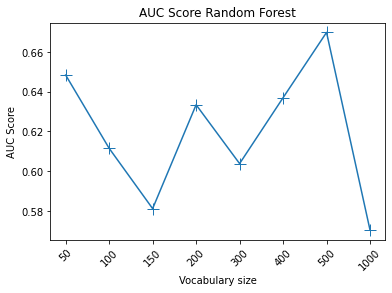

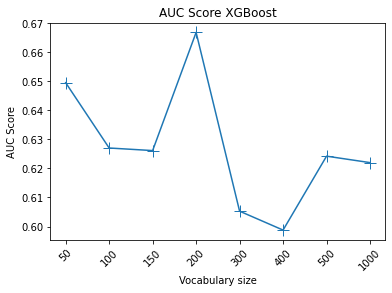

In [43]:
xgb_roc_scores = []
rf_roc_scores = []
max_features = [50, 100, 150, 200, 300, 400, 500, 1000]

multi_output = MultiLabelBinarizer()
y = multi_output.fit_transform([set(movie_tropes) for movie_tropes in movie_tropes_subset_dict.values()])

X_train_docs, X_test_docs, y_train, y_test = train_test_split(list(all_preprocess_movie_dialogs.values()), y, 
                                                              train_size=0.8)

print(len(X_train_docs), len(X_test_docs), y_train.shape, y_test.shape)

X_train_tfidf_docs = [' '.join(list(x)) for x in X_train_docs]
X_test_tfidf_docs = [' '.join(list(x)) for x in X_test_docs]

trope_of_interest = "ShoutOut"
trope_idx = trope_idx = list(multi_output.classes_).index(trope_of_interest)
multi_output = False
y_train_trope = y_train[:, trope_idx].copy()
y_test_trope = y_test[:, trope_idx].copy()
print(f"{trope_of_interest}: train ({y_train_trope.sum()}), test ({y_test_trope.sum()})")

for feature in max_features:
    tfidf_fit = TfidfVectorizer(max_features=feature, stop_words='english').fit(raw_documents=X_train_tfidf_docs)
    X_tfidf_train_vec = tfidf_fit.transform(X_train_tfidf_docs)
    X_tfidf_test_vec = tfidf_fit.transform(X_test_tfidf_docs)

    rf_auc_class = train_eval_classifiers(X_tfidf_train_vec, X_tfidf_test_vec, y_train_trope, y_test_trope, 
                                          classifier='rf', multi_output=multi_output, n_estimators = 100)
    xgb_auc_class = train_eval_classifiers(X_tfidf_train_vec, X_tfidf_test_vec, y_train_trope, 
                                           y_test_trope, multi_output=multi_output, n_estimators = 100)
    #     print(f'Vocabulary size: {feature}')
    if multi_output:
        print(f"RF Mean AUC: {round(np.mean(rf_auc_class), 2)}, RF Median AUC: {round(np.median(rf_auc_class), 2)}, RF Min AUC: {round(np.min(rf_auc_class), 2)}, RF Max AUC: {round(np.max(rf_auc_class), 2)}")
        print(f"XGB Mean AUC: {round(np.mean(xgb_auc_class), 2)}, XGB Median AUC: {round(np.median(xgb_auc_class), 2)}, XGB Min AUC: {round(np.min(xgb_auc_class), 2)}, XGB Max AUC: {round(np.max(xgb_auc_class), 2)}")
    else:
        rf_roc_scores.append(rf_auc_class)
        xgb_roc_scores.append(xgb_auc_class)

plot_auc_scores(rf_roc_scores, max_features, "Random Forest")
plot_auc_scores(xgb_roc_scores, max_features, "XGBoost")

## Train Doc2Vec model on Movie Scripts

In [ ]:
# Convert documents to TaggedDocument to train doc2vec models
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_preprocess_movie_dialogs.values())]
len(documents)

## Train doc2vec vectors and train xgboost classifier

In [ ]:
vector_size = [200, 300, 500, 1000]
window_size = [20, 30]
epochs = [10]

for v in vector_size:
    for w in window_size:
        for e in epochs:
            dm_model = Doc2Vec(X_train_docs, vector_size=v, window=w, epochs=e, 
                            min_count=5, dm=1)
            dbow_model = Doc2Vec(X_train_docs, vector_size=v, window=w, epochs=e, 
                            min_count=5, dm=0)
            
            X_train_dm_dv = []
            X_train_dbow_dv = []
            
            X_test_dm_dv = []
            X_test_dbow_dv = []
            
            for i in range(len(X_train_docs)):
                X_train_dm_dv.append(dm_model.docvecs[i])
                X_train_dbow_dv.append(dbow_model.docvecs[i])

            for i in range(len(X_test_docs)):
                X_test_dm_dv.append(dm_model.infer_vector(X_test_docs[i][0]))
                X_test_dbow_dv.append(dbow_model.infer_vector(X_test_docs[i][0]))
                
            X_train_dv = pd.concat([pd.DataFrame(X_train_dm_dv),
                                            pd.DataFrame(X_train_dbow_dv)], axis=1)
            X_test_dv = pd.concat([pd.DataFrame(X_test_dm_dv),
                                             pd.DataFrame(X_test_dbow_dv)], axis=1)

#             _fit = RandomForestClassifier(n_estimators=50)
            xgb_auc_class = train_eval_classifiers(X_train_dv, X_test_dv, y_train, y_test)
            rf_auc_class = train_eval_classifiers(X_train_dv, X_test_dv, y_train, y_test, classifier='rf')
            print(f'Vector size: {v}, Window size: {w}, Epoch: {e}')
            print(f"Mean AUC: {round(np.mean(xgb_auc_class), 2)}, Median AUC: {round(np.median(xgb_auc_class), 2)}, Min AUC: {round(np.min(xgb_auc_class), 2)}, Max AUC: {round(np.max(xgb_auc_class), 2)}")
            print(f"Mean AUC: {round(np.mean(rf_auc_class), 2)}, Median AUC: {round(np.median(rf_auc_class), 2)}, Min AUC: {round(np.min(rf_auc_class), 2)}, Max AUC: {round(np.max(rf_auc_class), 2)}")

In [ ]:
pd.concat([pd.DataFrame([[1,2,3]]), pd.DataFrame([[4,5,6]])], axis=1)

In [ ]:
dm_model.docvecs[0]